In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load dataset
ratings = pd.read_csv("/kaggle/input/movielens-25m-dataset/ml-25m/ratings.csv")
movies = pd.read_csv("/kaggle/input/movielens-25m-dataset/ml-25m/movies.csv")
links = pd.read_csv("/kaggle/input/movielens-25m-dataset/ml-25m/links.csv")

In [3]:
print("="*50)
print("THỐNG KÊ DỮ LIỆU")
print("="*50)
print(f"Ratings: {ratings.shape[0]} đánh giá, {ratings['userId'].nunique()} người dùng")
print(f"Movies: {movies.shape[0]} phim")

THỐNG KÊ DỮ LIỆU
Ratings: 25000095 đánh giá, 162541 người dùng
Movies: 62423 phim


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


# Phân tích khám phá dữ liệu (EDA)

**Biểu đồ tần suất theo điểm đánh giá**

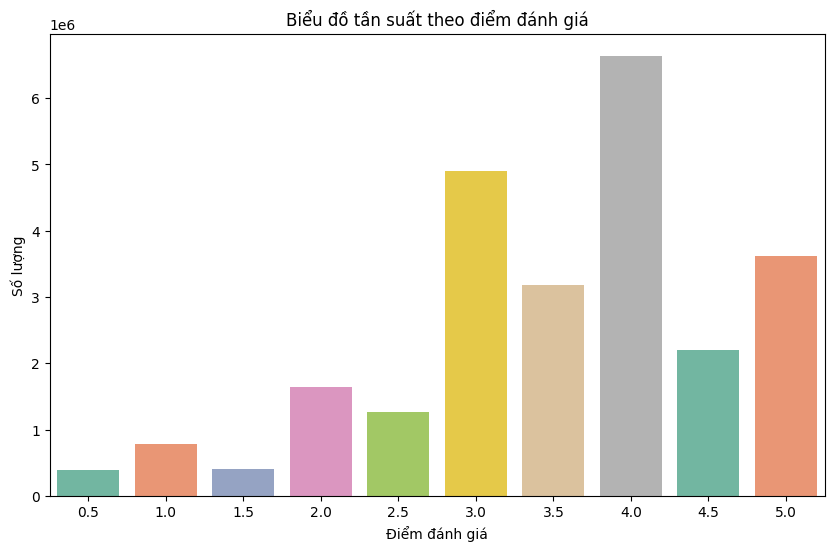

In [7]:
# Vẽ biểu đồ 
plt.figure(figsize=(10, 6))
sns.countplot(data=ratings, x='rating', palette='Set2')
plt.title('Biểu đồ tần suất theo điểm đánh giá')
plt.xlabel('Điểm đánh giá')
plt.ylabel('Số lượng')
plt.show()

**Nhận xét:**
- Phần lớn các đánh giá tập trung ở mức cao, từ 3.0 đến 5.0, có sự sụt giảm ở các mức ratings thấp.
- Rating 4.0 là phổ biến nhất với số lượng đánh giá cao nhất, rating 3.0 đứng thứ hai về tần suất. Mặc dù không cao bằng 4.0 và 3.0, nhưng rating 5.0 vẫn có số lượng đáng kể, cho thấy nhiều người dùng vẫn rất hài lòng.
- Các ratings thấp (0.5, 1.0, 1.5) có tần suất thấp nhất.

=> Dữ liệu cho thấy xu hướng đánh giá tích cực, với phần lớn người dùng hài lòng (ratings từ 3.5 trở lên). Các đánh giá tiêu cực (dưới 2.5) chiếm một tỷ lệ rất nhỏ. Điều này có thể gợi ý rằng phim được đánh giá khá tốt và nhận được phản hồi tích cực từ phần lớn người dùng.

## Phân tích theo phim

**Top 20 bộ phim có số lượt đánh giá nhiều nhất**

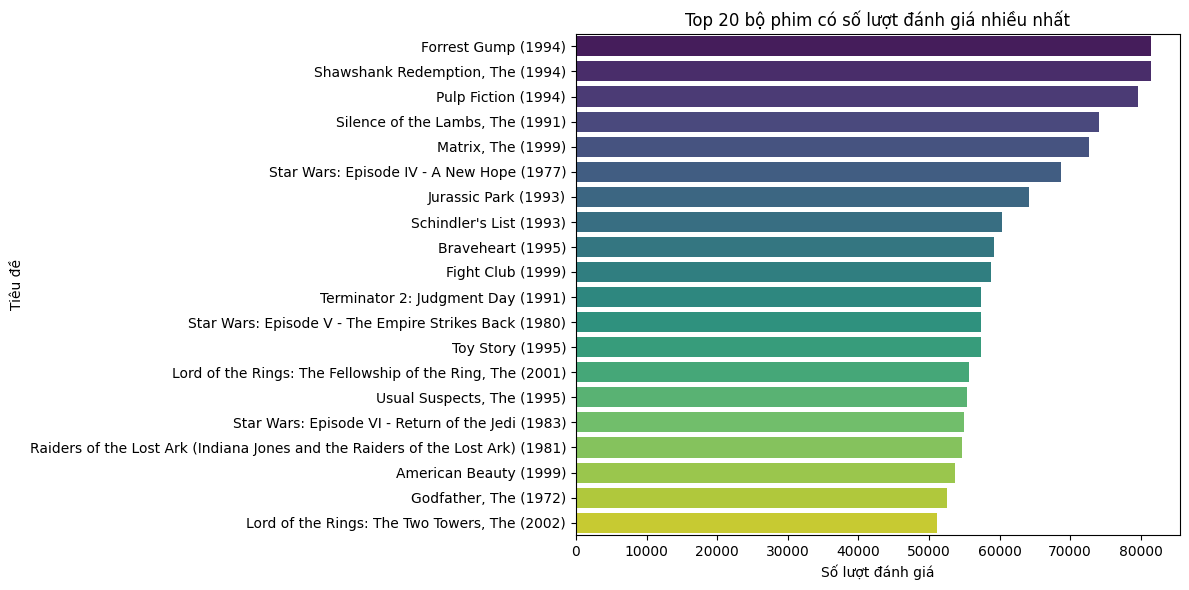

In [8]:
# Lấy danh sách 20 bộ phim có số lượt đánh giá cao nhất
top_movies = ratings['movieId'].value_counts().head(20)
# Tạo DataFrame 
top_movies = pd.DataFrame({'movieId': top_movies.index, 'num_ratings': top_movies.values})
# Gộp dữ liệu với bảng 'movies' để lấy tên phim
top_movies = top_movies.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(y='title', x='num_ratings', data=top_movies, palette='viridis')
plt.title('Top 20 bộ phim có số lượt đánh giá nhiều nhất')
plt.xlabel('Số lượt đánh giá')
plt.ylabel('Tiêu đề')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Phim "Forrest Gump (1994)" đứng đầu bảng với số lượt đánh giá cao nhất, cho thấy đây là bộ phim rất được yêu thích.
- Đa số các phim trong danh sách từ thập niên 1990 chiếm ưu thế rõ rệt. Điều này có thể do đây là thời kỳ vàng son của điện ảnh, tạo ra nhiều tác phẩm có sức ảnh hưởng lâu dài, phù hợp  với độ tuổi người dùng thường tham gia đánh giá.
- Các phim năm 1994 chiếm tỷ lệ lớn trong top đầu (Forrest Gump, Shawshank Redemption, Pulp Fiction), thể hiện một năm đầy sức hút của các vũ trụ điện ảnh lớn.
- Các loạt phim nổi tiếng như Star Wars, Godfather và Raiders of the Lost Ark đều có mặt trong danh sách, chứng minh tầm ảnh hưởng vượt thời gian của nó.

=> Những bộ phim này đều được đánh giá cao cả về chất lượng nội dung lẫn độ phổ biến, nên có xu hướng được nhiều người xem và đánh giá. Nó cho thấy sự pha trộn giữa các tác phẩm kinh điển từ nhiều thập kỷ trước và các bộ phim nổi bật của những năm 1990-2000, chứng tỏ rằng sự yêu thích và sự đánh giá của khán giả không chỉ giới hạn ở các phim mới ra mắt.

**Top 20 bộ phim có điểm trung bình cao nhất**

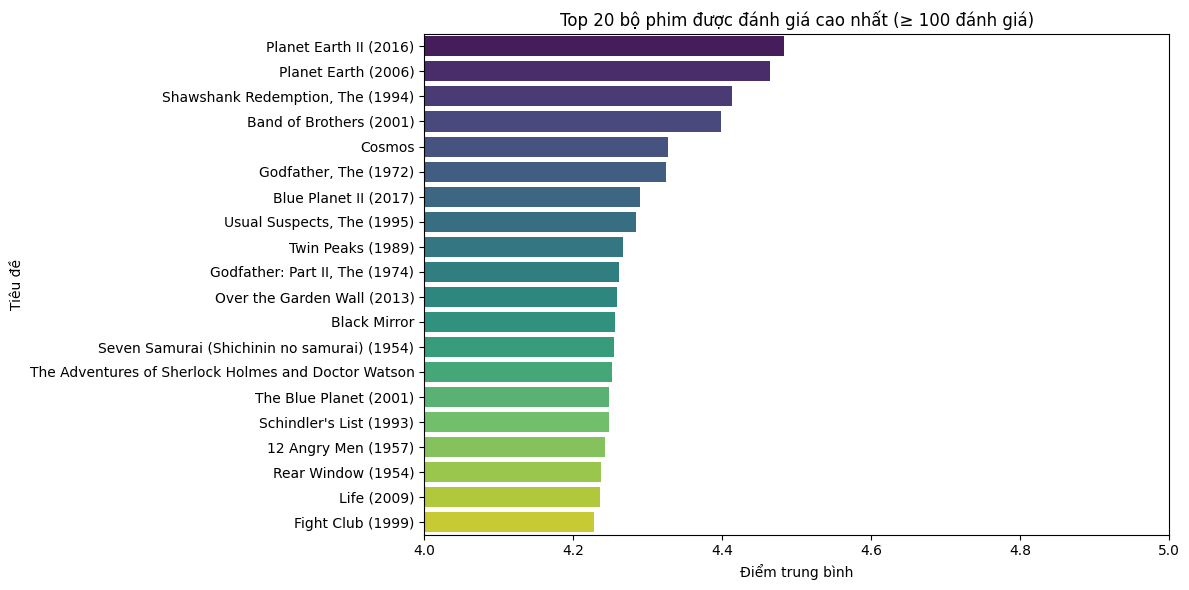

In [9]:
# Tính điểm trung bình và số lượt đánh giá cho từng phim
movie_stats = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'count')
).reset_index()

# Lọc các bộ phim có ít nhất 100 đánh giá
popular_movies = movie_stats[movie_stats['rating_count'] >= 100]
# Lấy 20 bộ phim có điểm trung bình cao nhất
top_rated = popular_movies.sort_values(by='avg_rating', ascending=False).head(20)
# Gộp với bảng 'movies' để lấy title của phim
top_rated = top_rated.merge(movies[['movieId', 'title']], on='movieId')

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='title', data=top_rated, palette='viridis')
plt.title('Top 20 bộ phim được đánh giá cao nhất (≥ 100 đánh giá)')
plt.xlabel('Điểm trung bình')
plt.ylabel('Tiêu đề')
plt.xlim(4, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Các bộ phim trải dài từ thập niên 1950 đến thập niên 2010, cho thấy chất lượng không phụ thuộc thời gian.
- 20 bộ phim trong danh sách đều có điểm trung bình từ 4.2 trở lên, và nhiều bộ phim đạt gần 4.5. Điều này chứng tỏ chúng được đánh giá xuất sắc cả về nội dung lẫn hình thức.
- Một số bộ phim xuất hiện trong cả hai danh sách (Shawshank Redemption, Godfather, Fight Club), chứng tỏ chúng vừa phổ biến vừa có chất lượng cao.

=> Biểu đồ cho thấy sự đa dạng về thể loại và thời kỳ, đặc biệt là sự hiện diện mạnh mẽ của các bộ phim tài liệu và các tác phẩm điện ảnh/truyền hình kinh điển.

## Phân tích theo thể loại

In [10]:
# Nối dữ liệu từ bảng 'ratings' và 'movies'
merged = ratings.merge(movies, on='movieId')
# Loại bỏ các bộ phim không có thể loại
merged = merged[merged['genres'] != '(no genres listed)']
# Tách các thể loại thành list rồi tách thành các dòng riêng biệt
merged['genres'] = merged['genres'].str.split('|')
exploded = merged.explode('genres')
exploded.head()

,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy
0,1,296,5.0,1147880044,Pulp Fiction (1994),Crime
0,1,296,5.0,1147880044,Pulp Fiction (1994),Drama
0,1,296,5.0,1147880044,Pulp Fiction (1994),Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama


**Biểu đồ phân phối của thể loại phim**

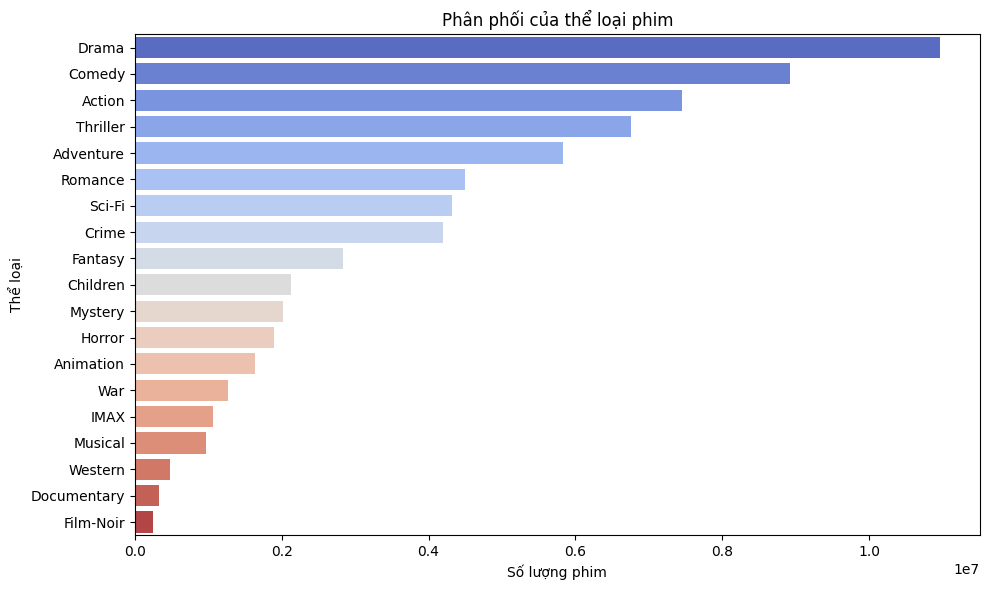

In [11]:
# Đếm số lượng phim theo từng thể loại
genre_counts = exploded['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_counts, x='count', y='genre', palette='coolwarm')
plt.title('Phân phối của thể loại phim')
plt.xlabel('Số lượng phim')
plt.ylabel('Thể loại')
plt.tight_layout()
plt.show()

**Nhận xét:**
- Danh sách bao gồm 19 thể loại khác nhau, điều này cho thấy sự phong phú trong nội dung phim được khảo sát.
- Có một sự chênh lệch lớn về số lượng giữa các thể loại hàng đầu (Drama, Comedy, Action) và các thể loại ở cuối danh sách.
- Drama (kịch tính) dẫn đầu với số lượng phim cao nhất, cho thấy đây là thể loại được sản xuất nhiều nhất và có sức hút lớn.
- Các thể loại như Comedy, Action, Thriller thuộc nhóm phổ biến, phản ánh sự yêu thích của khán giả đối với các thể loại giải trí đại chúng.
- Film-Noir, Documentary, Western và Musical nằm ở đáy bảng do đặc thù thể loại, khó sản xuất hoặc đối tượng khán giả hẹp.

=> Có một sự chênh lệch lớn về số lượng giữa các thể loại hàng đầu và các thể loại ở cuối danh sách. Phân phối cho thấy sự tập trung đáng kể vào các thể loại truyền thống và phổ biến rộng rãi như chính kịch, hài và hành động, trong khi các thể loại chuyên biệt hơn như Film-Noir hoặc Documentary có số lượng khiêm tốn hơn nhiều. Thông tin này có thể hữu ích cho việc hiểu thị trường phim, xu hướng sản xuất hoặc sở thích chung của khán giả.

**Biểu đồ cho thấy trung bình điểm đánh giá theo thể loại**

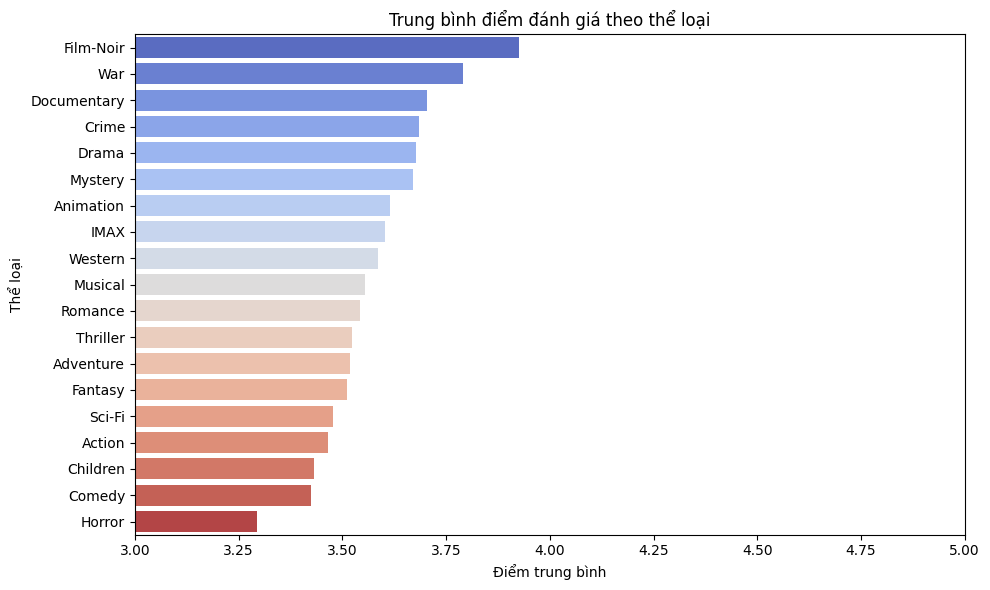

In [12]:
# Tính trung bình điểm đánh giá theo thể loại phim
genre_avg = exploded.groupby('genres')['rating'].mean().reset_index()
genre_avg.columns = ['genre', 'avg_rating']
# Sắp xếp điểm trung bình từ cao đến thấp
genre_avg = genre_avg.sort_values(by='avg_rating', ascending=False)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(data=genre_avg, x='avg_rating', y='genre', palette='coolwarm')
plt.title('Trung bình điểm đánh giá theo thể loại')
plt.xlabel('Điểm trung bình')
plt.ylabel('Thể loại')
plt.xlim(3, 5)
plt.tight_layout()
plt.show()

**Nhận xét:**
- Film-Noir, War và Documentary là những thể loại có điểm trung bình cao nhất (>3.7), cho thấy đây là các thể loại được đánh giá nghiêm túc và có chiều sâu nội dung.
- Crime, Drama, và Mystery cũng nằm trong nhóm điểm cao, phản ánh sở thích người dùng nghiêng về các nội dung phức tạp, kịch tính và tâm lý.
- Các thể loại như Animation, IMAX, Western, Musical, và Romance có điểm trung bình ổn định (~3.5–3.6), thể hiện sự yêu thích đồng đều từ nhiều nhóm người dùng khác nhau.
- Comedy, Children và đặc biệt là Horror có điểm trung bình thấp nhất, với Horror chỉ xấp xỉ ~3.3. Điều này có thể do thể loại này mang tính giải trí, dễ gây chia rẽ cảm nhận, hoặc chất lượng phim không đồng đều.

## Phân tích theo thời gian

**Biểu đồ cho thấy số lượng đánh giá theo năm**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


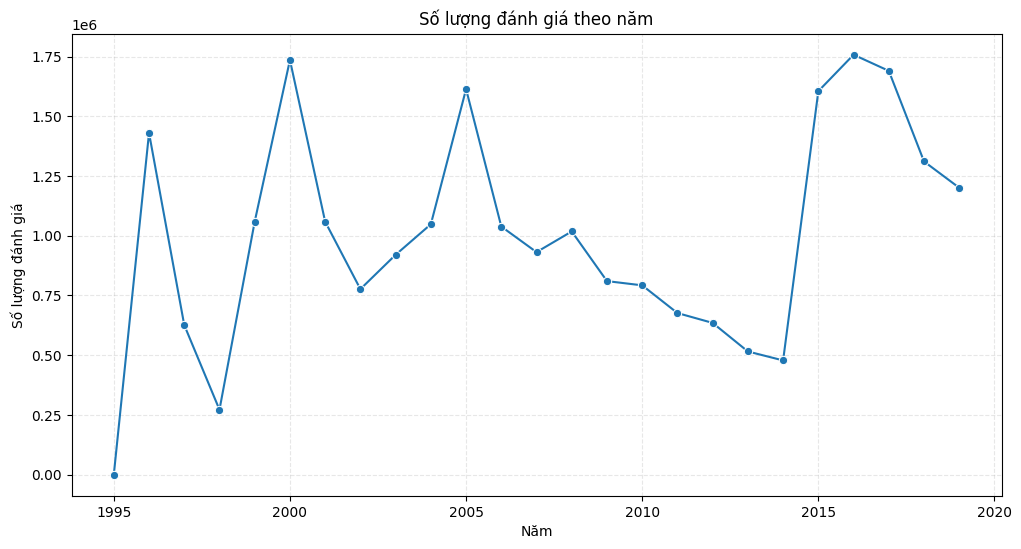

In [13]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy năm
ratings['year'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
# Đếm số đánh giá theo từng năm
ratings_by_year = ratings['year'].value_counts().sort_index()

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.lineplot(x=ratings_by_year.index, y=ratings_by_year.values, marker='o')
plt.title('Số lượng đánh giá theo năm')
plt.xlabel('Năm')
plt.ylabel('Số lượng đánh giá')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

**Nhận xét:**
- **Giai đoạn khởi đầu (1995–1998):** Số lượt đánh giá còn thấp và biến động mạnh. Năm 1996 là đỉnh cao đầu tiên với hơn 1.4 triệu lượt đánh giá, nhưng sau đó giảm mạnh vào năm 1998.
- **Giai đoạn 1999–2001:** Năm 2000 ghi nhận số lượng đánh giá cao nhất trong giai đoạn này (~1.75 triệu lượt). Điều này trùng khớp với xu hướng được thấy trong heatmap và có thể phản ánh một sự kiện thu hút lượng lớn người dùng.
- **Giai đoạn 2002–2010:** Số lượt đánh giá duy trì ở mức trung bình từ 0.75 đến 1 triệu, nhưng có xu hướng giảm dần từ năm 2006 trở đi.
- **Giai đoạn 2011–2014:** Lượng đánh giá tiếp tục giảm, đạt mức thấp nhất vào năm 2014 (~500,000 lượt), cho thấy mức độ hoạt động người dùng suy giảm rõ rệt.
- **Giai đoạn 2015–2017:** Tăng trưởng mạnh trở lại, với năm 2016 đạt mức đỉnh mới (~1.8 triệu lượt). Có thể do tái khởi động nền tảng, chiến dịch quảng bá, hoặc tích hợp vào hệ thống lớn hơn.
- **Giai đoạn 2018–2019:** Số lượng đánh giá giảm nhẹ nhưng vẫn giữ mức cao (~1.2 triệu), phản ánh sự duy trì hoạt động tốt của cộng đồng người dùng.

**Biểu đồ heatmap: số lượt đánh giá theo năm và tháng**

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


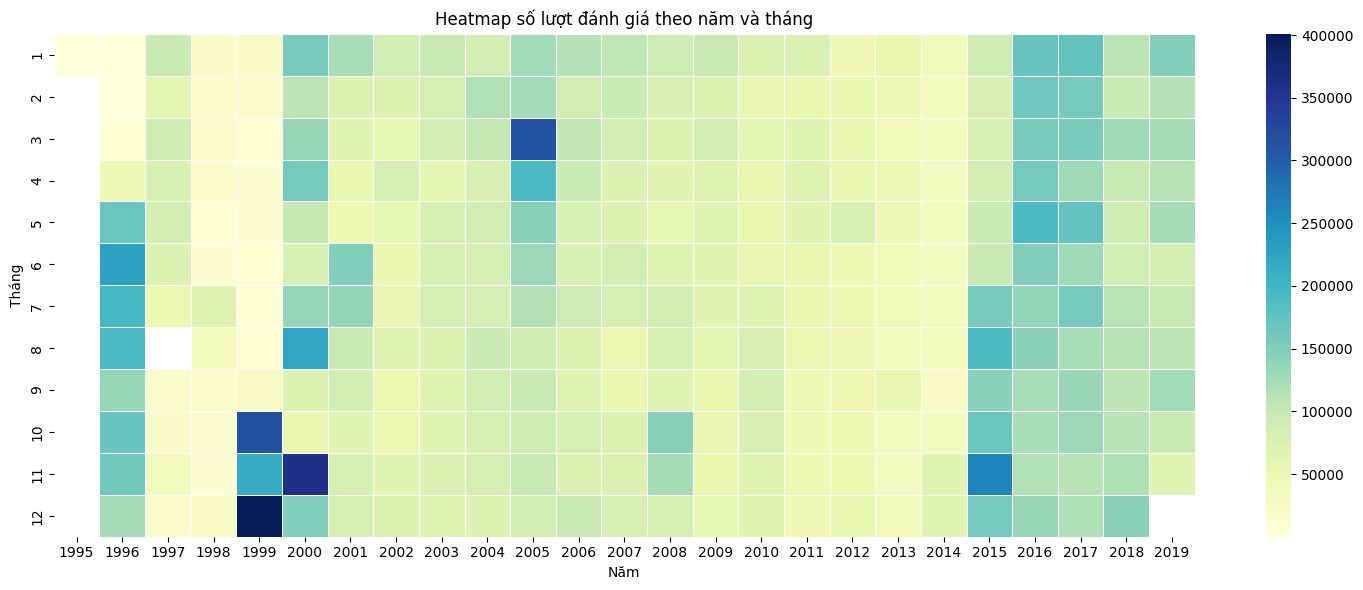

In [14]:
# Chuyển cột 'timestamp' sang kiểu datetime và lấy theo tháng (Year-Month)
ratings['year_month'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.to_period('M')
# Đếm số lượt đánh giá theo tháng và năm
ratings_heatmap = ratings.groupby(ratings['year_month']).size().reset_index(name='count')
ratings_heatmap['year'] = ratings_heatmap['year_month'].dt.year
ratings_heatmap['month'] = ratings_heatmap['year_month'].dt.month

# Tạo bảng pivot với tháng là index và năm là cột
pivot_table = ratings_heatmap.pivot(index='month', columns='year', values='count')

# Vẽ biểu đồ
plt.figure(figsize=(15, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', linewidths=0.5, annot=False)
plt.title('Heatmap số lượt đánh giá theo năm và tháng')
plt.xlabel('Năm')
plt.ylabel('Tháng')
plt.tight_layout()
plt.show()

**Nhận xét:**
- **Giai đoạn 1995–1997:** Số lượt đánh giá còn rất thấp, thậm chí có tháng gần như không có lượt đánh giá nào. Đây là giai đoạn đầu nên dữ liệu còn hạn chế.
- **Đột biến trong năm 1999–2000:** 
  - Tháng 12 năm 1999 ghi nhận lượt đánh giá cao nhất toàn bộ tập dữ liệu (>400,000), thể hiện bằng ô có màu xanh đậm nhất.
  - Các tháng 10 và 11 năm 1999, cũng như các tháng 5 và 8 năm 2000, cũng có lượng đánh giá cao bất thường.
  - Có thể do một sự kiện đặc biệt (chẳng hạn cập nhật dữ liệu hoặc là thời điểm phát hành dữ liệu lớn).
- **Giai đoạn 2004–2006:** Tăng trưởng rõ rệt, đặc biệt là tháng 3 năm 2005 có số lượt đánh giá cao đột biến. Giai đoạn này phản ánh sự mở rộng sử dụng của hệ thống hoặc nền tảng đánh giá.
- **Giai đoạn 2015–2018:** Lượt đánh giá tăng trở lại ở nhiều tháng, đặc biệt là tháng 11 năm 2016. Điều này cho thấy sự phục hồi hoặc là sự phát triển lại của cộng đồng người dùng đánh giá phim.
- **Giai đoạn sau 2010:** Mặc dù không có đột biến lớn, lượt đánh giá duy trì ở mức trung bình ổn định ở các tháng, cho thấy mức độ hoạt động đều đặn hơn từ cộng đồng.

**Biểu đồ điểm đánh giá trung bình theo từng tháng qua các năm**

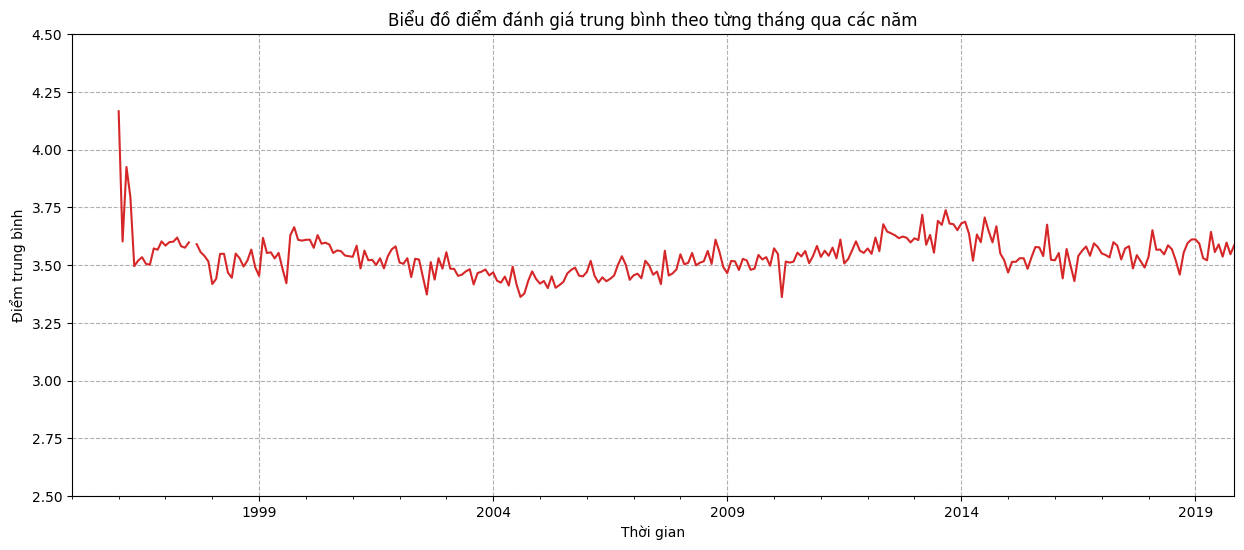

In [15]:
# Chuyển cột 'timestamp' sang kiểu datetime và gán về ngày
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')
# Tính điểm trung bình mỗi tháng (resample theo cuối tháng)
ratings.set_index('date')['rating'].resample('ME').mean().plot(figsize=(15, 6), color='tab:red')

# Vẽ biểu đồ
plt.title('Biểu đồ điểm đánh giá trung bình theo từng tháng qua các năm')
plt.xlabel('Thời gian')
plt.ylabel('Điểm trung bình')
plt.ylim(2.5, 4.5)
plt.grid(True, linestyle='--')
plt.show()

**Nhận xét:**
- **Giai đoạn đầu (1996–1998):** Xuất hiện nhiều dao động mạnh, trong đó có những tháng điểm trung bình vượt 4.0. Điều này có thể do lượng người dùng còn ít, dẫn đến dễ bị ảnh hưởng bởi các đánh giá cực đoan (outliers).
- **Giai đoạn 1999–2010:** Điểm trung bình ổn định hơn, dao động trong khoảng 3.4 đến 3.6. Phản ánh hành vi đánh giá của người dùng trở nên nhất quán và khách quan hơn khi hệ thống có lượng dữ liệu lớn hơn.
- **Giai đoạn 2011–2015:** Có một số thời điểm điểm trung bình tăng nhẹ, vượt mốc 3.7. Điều này có thể liên quan đến các bộ phim nổi bật hoặc sự tham gia tích cực hơn của người dùng yêu thích.
- **Giai đoạn 2016–2019:** Xu hướng điểm trung bình có xu hướng giảm nhẹ và dao động xung quanh mức 3.5. Điều này cho thấy người dùng dần trở nên khó tính hơn hoặc đánh giá khắt khe hơn qua thời gian.

# Tiền xử lý dữ liệu (Pre-processing data)

In [16]:
# Kiểm tra ratings hợp lệ (0.5 đến 5.0)
if (ratings['rating'] < 0.5).any() or (ratings['rating'] > 5.0).any():
    print("Warning: Invalid rating values detected.")

In [17]:
# Tính số lượng người dùng, phim và tổng số lượt đánh giá
n_users = ratings['userId'].nunique()
n_movies = ratings['movieId'].nunique()
n_ratings = len(ratings)

# Tính độ thưa (sparsity) của ma trận ratings
sparsity = 1 - n_ratings / (n_users * n_movies)
print(f"\nĐộ thưa của ma trận: {sparsity:.4f} ({n_ratings} ratings / {n_users * n_movies} possible ratings)")


Độ thưa của ma trận: 0.9974 (25000095 ratings / 9597558427 possible ratings)


In [18]:
# Nối bảng 'ratings' với 'movies' để lấy tiêu đề phim
df = pd.merge(ratings, movies, on='movieId')

# Truncated SVD

In [19]:
def truncated_svd(X, n_components=30):
    """
    Tính Truncated SVD (Singular Value Decomposition) cho ma trận thưa X.

    Tham số:
        X: Ma trận thưa (users x movies)
        n_components: Số lượng thành phần chính (rank giảm chiều)
    
    Các bước thực hiện:
        1. Tính X.T @ X (movies x movies)
        2. Phân tích eigen: lấy top k các trị riêng (eigenvalues) và vector riêng (eigenvectors) lớn nhất
        3. Tính các giá trị kỳ dị (singular values) bằng căn bậc hai của eigenvalues
        4. Tính ma trận U = X @ V / Sigma
        5. Dựng lại ma trận xấp xỉ: X ~ U * Sigma * V^T

    Trả về:
        - X_approx: Ma trận xấp xỉ gốc với rank thấp hơn
    """

    # Bước 1: X.T @ X
    C = X.T.dot(X)

    # Bước 2: Phân tích eigen (chỉ lấy top k)
    eigenvalues, eigenvectors = eigsh(C, k=n_components, which='LM')

    # Bước 3: Sắp xếp các trị riêng theo thứ tự giảm dần
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Bước 4: Tính singular values từ eigenvalues
    Sigma = np.sqrt(eigenvalues)

    # Bước 5: Tính ma trận U
    U = X.dot(eigenvectors)
    U = U / Sigma[np.newaxis, :]

    Vt = eigenvectors.T

    # Step 6: Dựng lại ma trận xấp xỉ
    X_approx = U @ np.diag(Sigma) @ Vt

    return X_approx, U, Sigma, Vt

In [20]:
# from scipy.sparse import coo_matrix

# def svd_baseline_predict(ratings_df, user_enc, movie_enc, k=50):
#     """
#     Dự đoán rating bằng phương pháp SVD có chuẩn hóa (phiên bản đơn giản của Iterative SVD) theo người dùng.

#     Tham số:
#         ratings_df: DataFrame chứa các cột ['user_idx', 'movie_idx', 'rating']
#         user_enc, movie_enc: LabelEncoder đã fit
#         k: Số lượng thành phần ẩn (rank giảm chiều)
        
#     Các bước thực hiện:
#         1. Khởi tạo ma trận rating rời rạc từ dữ liệu.
#         2. Tính trung bình ratings theo từng hàng (user).
#         3. Mean-center ma trận bằng cách trừ trung bình từng user.
#         4. Áp dụng Truncated SVD để xấp xỉ ma trận chuẩn hóa.
#         5. Cộng lại trung bình user để khôi phục thang điểm ban đầu.

#     Trả về:
#         R_hat: Ma trận dự đoán (users x movies)
#         R: Ma trận gốc ở dạng sparse
#         row_means: Giá trị trung bình ratings theo từng user
#     """

#     # Kiểm tra tính hợp lệ của dữ liệu đầu vào
#     required_columns = ['user_idx', 'movie_idx', 'rating']
#     if not all(col in ratings_df.columns for col in required_columns):
#         raise ValueError(f"ratings_df must contain columns: {required_columns}")
#     if ratings_df[required_columns].isnull().any().any():
#         raise ValueError("ratings_df contains NaN values.")

#     ratings_df = ratings_df.copy()

#     n_users = len(user_enc.classes_)
#     n_movies = len(movie_enc.classes_)

#     if k > min(n_users, n_movies):
#         raise ValueError(f"k={k} is too large. Must be <= {min(n_users, n_movies)}")

#     # Bước 1: Tạo sparse matrix từ ratings gốc
#     row = ratings_df['user_idx'].values
#     col = ratings_df['movie_idx'].values
#     data = ratings_df['rating'].values
#     R = coo_matrix((data, (row, col)), shape=(n_users, n_movies))

#     #  Bước 2: Tính trung bình ratings theo từng user (row_means)
#     row_sums = np.array(R.sum(axis=1)).flatten()
#     row_counts = np.array((R != 0).sum(axis=1)).flatten()
#     row_means = np.zeros(n_users)
#     mask = row_counts > 0
#     row_means[mask] = row_sums[mask] / row_counts[mask]

#     # Bước 3: Chuẩn hóa ma trận bằng cách trừ trung bình mỗi user (Mean-center)
#     R_centered = R.copy()
#     R_centered.data -= row_means[R_centered.row]

#     # Bước 4: Áp dụng Truncated SVD lên ma trận chuẩn hóa
#     U, S, Vt = truncated_svd(R_centered, n_components=k)

#     # Bước 5: Khôi phục lại ma trận dự đoán ban đầu
#     R_hat_centered = U @ np.diag(S) @ Vt
#     R_hat = R_hat_centered + row_means[:, np.newaxis]

#     return R_hat, R, row_means

# Chia tập dữ liệu và Đánh giá

In [21]:
# Lọc 1000 người dùng đánh giá nhiều nhất
sample_users = df['userId'].value_counts().head(1000).index
sample_df = df[df['userId'].isin(sample_users)].copy()

# Mã hóa userId và title thành chỉ số để xây dựng ma trận
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
sample_df['user_idx'] = user_encoder.fit_transform(sample_df['userId'])
sample_df['movie_idx'] = movie_encoder.fit_transform(sample_df['title'])

# Chia dữ liệu thành tập huấn luyện và kiểm tra (train và test)
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=42)

# Tạo ma trận thưa từ tập train (users x movies)
train_matrix = csr_matrix((train_df['rating'], (train_df['user_idx'], train_df['movie_idx'])),
                          shape=(sample_df['user_idx'].nunique(), sample_df['movie_idx'].nunique()))

# Áp dụng Truncated SVD để giảm chiều
X_approx, U, Sigma, Vt = truncated_svd(train_matrix, n_components=30)

In [22]:
def evaluate_metric(df, X_approx):
    """
    Đánh giá chất lượng dự đoán của ma trận xấp xỉ so với ratings gốc.

    Tham số:
        df : Chứa các cột ['user_idx', 'movie_idx', 'rating']
        X_approx : Ma trận xấp xỉ

    Trả về:
        rmse : Root Mean Squared Error
        mae  : Mean Absolute Error
    """
    predictions, actuals = [], []

    for _, row in df.iterrows():
        u, m = row['user_idx'], row['movie_idx']
        # Chỉ xét những chỉ số hợp lệ (trong vùng của X_approx)
        if u < X_approx.shape[0] and m < X_approx.shape[1]:
            predictions.append(X_approx[u, m])
            actuals.append(row['rating'])

    # Tính sai số
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)
    return rmse, mae

# Đánh giá trên tập huấn luyện (train)
train_rmse, train_mae = evaluate_metric(train_df, X_approx)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")

# Đánh giá trên tập kiểm tra (test)
test_rmse, test_mae = evaluate_metric(test_df, X_approx)
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Train RMSE: 2.1261
Train MAE: 1.8688
Test RMSE: 2.3079
Test MAE: 2.0664


# Gợi ý phim

In [ ]:
def recommend_movies(user_id, user_encoder, movie_encoder, user_factors, movie_factors, movies_df, top_n=10):
    '''
    Gợi ý top_n phim cho user_id dựa trên SVD
    - user_id: ID gốc của người dùng
    - user_encoder, movie_encoder: LabelEncoder
    - user_factors, movie_factors: output từ Truncated SVD
    - movies_df: DataFrame chứa thông tin phim
    - top_n: số phim gợi ý
    '''
        
    # Lấy user_Id   
    user_idx = user_encoder.transform([user_id])[0]
    
    # Tính điểm đánh giá dự đoán
    scores =  movie_factors @ user_factors[user_idx]
    scores = np.clip(scores, 0.5, 5.0)
    
    # Lấy movieId gốc tương ứng với index
    movie_titles = movie_encoder.inverse_transform(np.arange(len(scores)))
    
    # Tạo DataFrame chứa kết quả
    recommendations = pd.DataFrame({
        'Tiêu đề': movie_titles,
        'Điểm đánh giá dự đoán': scores
    })
    
    return recommendations.sort_values('Điểm đánh giá dự đoán', ascending=False).head(top_n).reset_index(drop=True)

In [24]:
# Chọn ngẫu nhiên user_id
user_id = np.random.choice(user_encoder.classes_)

# Tính ma trận đặc trưng người dùng và phim từ kết quả SVD
user_factors = U @ np.diag(Sigma)
movie_factors = Vt.T

# Gợi ý phim cho người dùng được chọn
print(f"Gợi ý cho người dùng: {user_id}")
recommendations = recommend_movies(user_id, user_encoder, movie_encoder, user_factors, movie_factors, movies)
print(recommendations)

Gợi ý cho người dùng: 159192
                                             Tiêu đề  Điểm đánh giá dự đoán
0  Star Wars: Episode V - The Empire Strikes Back...               3.093862
1                    Ferris Bueller's Day Off (1986)               3.062996
2                         Princess Bride, The (1987)               3.039127
3                                    Clueless (1995)               2.951021
4                               Groundhog Day (1993)               2.948437
5                                Pulp Fiction (1994)               2.901244
6                         Grosse Pointe Blank (1997)               2.875703
7                                Mary Poppins (1964)               2.850273
8                         Edward Scissorhands (1990)               2.846511
9                                         Big (1988)               2.841735
